In [27]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from itertools import product
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datasets import get_real_dataset

random_seed = 0
torch.manual_seed(random_seed)
random.seed(random_seed)

# Entacmaea

In [61]:
dataset = get_real_dataset("Entacmaea")
# dataset.y = (dataset.y-torch.mean(dataset.y))/torch.std(dataset.y)

Loaded dataset from cache.


In [62]:
min(dataset.y)

tensor(0.1549)

In [63]:
def hadamard_matrix(n, normalize=False):
    '''
    Compute H_n, Hadamard matrix
    '''
    H1 = torch.asarray([[1.,1.], [1.,-1.]])
    H = torch.asarray([1.])
    for i in range(n):
        H = torch.kron(H, H1)
    if normalize:
        H = (1 / math.sqrt(2**n)) * H
    return H

def get_sample_inputs(n, b):
    hash_sigma = (torch.rand(b, n) < 0.5).float() # multivariate bernouli with p=0.5
    hash_inputs = torch.asarray(list((product((0.0,1.0), repeat=b))))

    sample_inputs = (hash_inputs @ hash_sigma) % 2
    return sample_inputs

# hadamard_matrix(3, normalize=False)
test_n = dataset.X.shape[1]
test_b = 8
sample_inputs = get_sample_inputs(test_n, test_b)
print(sample_inputs)

all_inputs = torch.asarray(list((product((0.0,1.0), repeat=dataset.X.shape[1]))))
# all_inputs = sample_inputs

landscape = dataset.y
H = hadamard_matrix(int(math.log2(len(landscape))), normalize=True)
spectrum = H @ landscape 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 0., 1.]])


In [64]:
degrees = torch.sum(dataset.X, axis=1)

sorted_freqs = sorted([(amp**2, int(freq_deg)) for amp, freq_deg in zip(spectrum.tolist()[1:], degrees.tolist()[1:])], reverse=True)
sorted_freqs[:1000]

[(470.2439997092333, 2),
 (258.8601784552193, 2),
 (200.58427786443735, 2),
 (85.14181000111057, 1),
 (71.49253912457789, 1),
 (13.177539547669369, 1),
 (11.817701196383723, 3),
 (10.617572740241087, 3),
 (10.138056507094916, 3),
 (7.341767919119832, 4),
 (7.327323747487981, 2),
 (6.876279258765464, 2),
 (5.614805569996918, 1),
 (4.5945824133105475, 3),
 (4.57035388848368, 4),
 (4.497457991453814, 3),
 (4.236449782652926, 3),
 (3.743024929520189, 3),
 (3.7140169788902, 4),
 (3.400911451331069, 4),
 (3.0266911687159705, 2),
 (2.792334636933461, 4),
 (2.5587211680488053, 4),
 (2.3598662659009193, 5),
 (2.2937550911911018, 3),
 (2.2505761753781286, 2),
 (1.9731872282740284, 3),
 (1.9267700601665325, 3),
 (1.9081862277511306, 1),
 (1.7732698655328392, 3),
 (1.7552795437061377, 3),
 (1.6544102237646854, 3),
 (1.6226615380970202, 3),
 (1.5244065826436923, 2),
 (1.4827610755476286, 4),
 (1.4221949873190312, 2),
 (1.415416741696518, 4),
 (1.200187881813136, 3),
 (1.1713646615568365, 3),
 (1.14

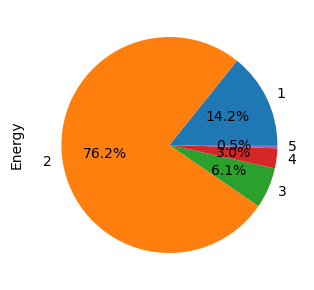

In [82]:
ax = pd.DataFrame(sorted_freqs[:100], columns=["Energy", "Freq Deg"]).groupby("Freq Deg").sum()\
            .plot.pie(y="Energy", autopct='%1.1f%%', legend=False, figsize=(4,3))
plt.tight_layout()
plt.savefig("Entacmaea_energy.pdf")

In [83]:
pd.DataFrame(sorted_freqs[:100], columns=["Energy", "Freq Deg"]).groupby("Freq Deg").sum()

,Energy
Freq Deg,
1,178.968665
2,957.900985
3,76.739942
4,37.457626
5,6.183025


In [29]:
mask = spectrum > 1
t_dot_f = dataset.X @ torch.t(dataset.X[mask])
computed_y = torch.sum(torch.where(t_dot_f % 2 == 1, -1, 1) * spectrum[mask], axis = -1) / math.sqrt(2**test_n)

In [30]:
r2_score(computed_y, landscape)

0.9229388079172898

# SGEMM

In [67]:
from sample_optimal_sparse_hadamard.fourier_extractor import get_fourier_time_samples_with_dummy_function, compute_fourier
from sample_optimal_sparse_hadamard.fourier import Fourier

In [68]:
dataset = get_real_dataset("SGEMM")

Loaded dataset from cache.
